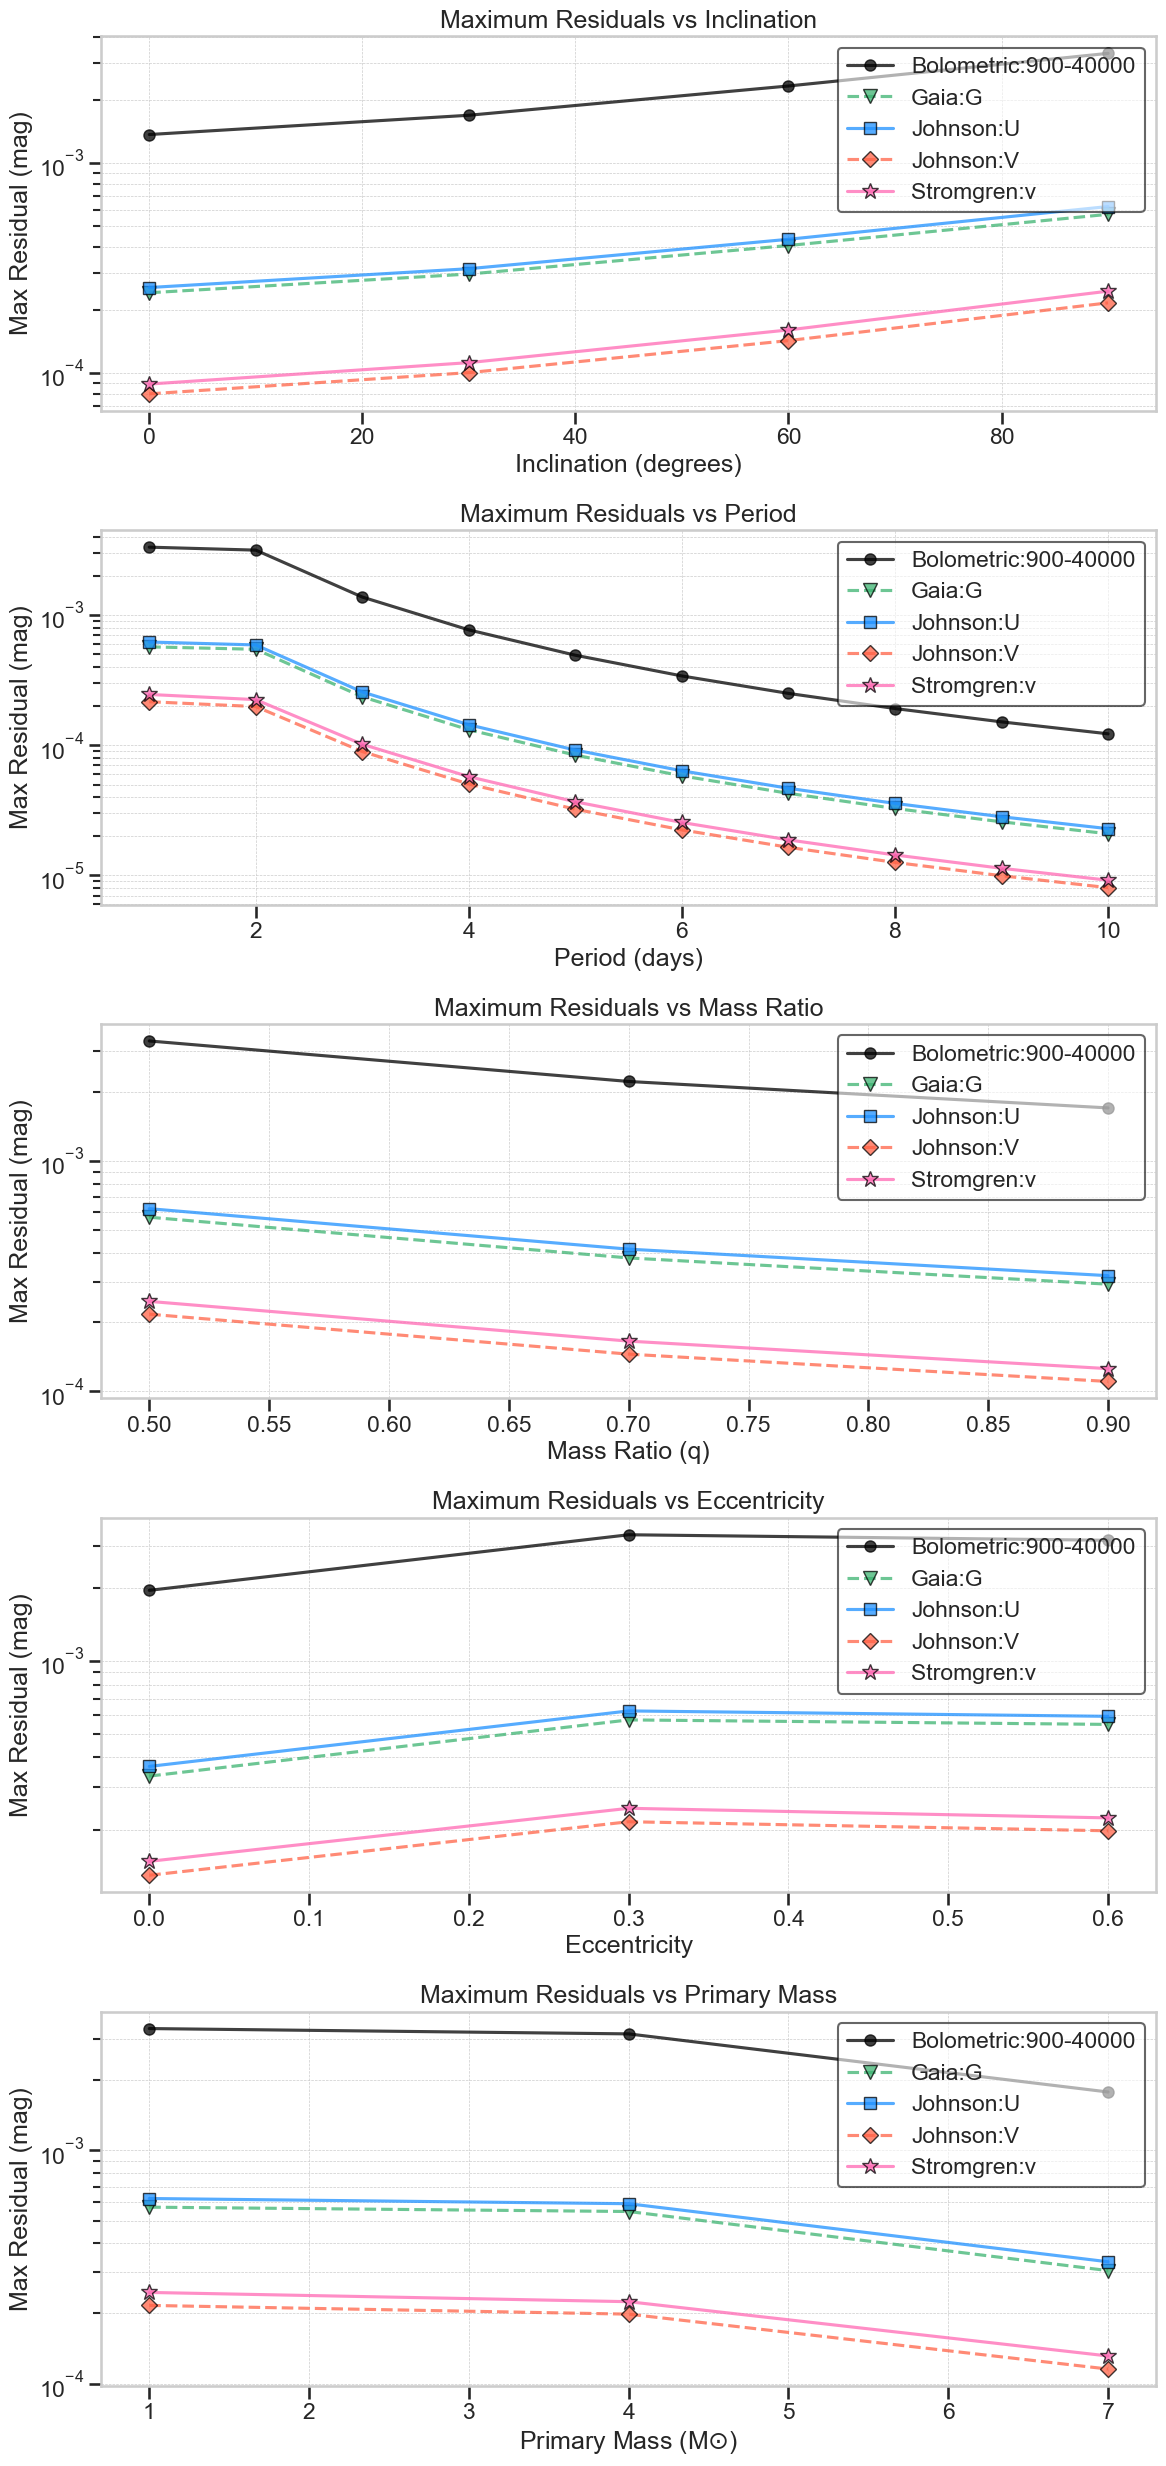

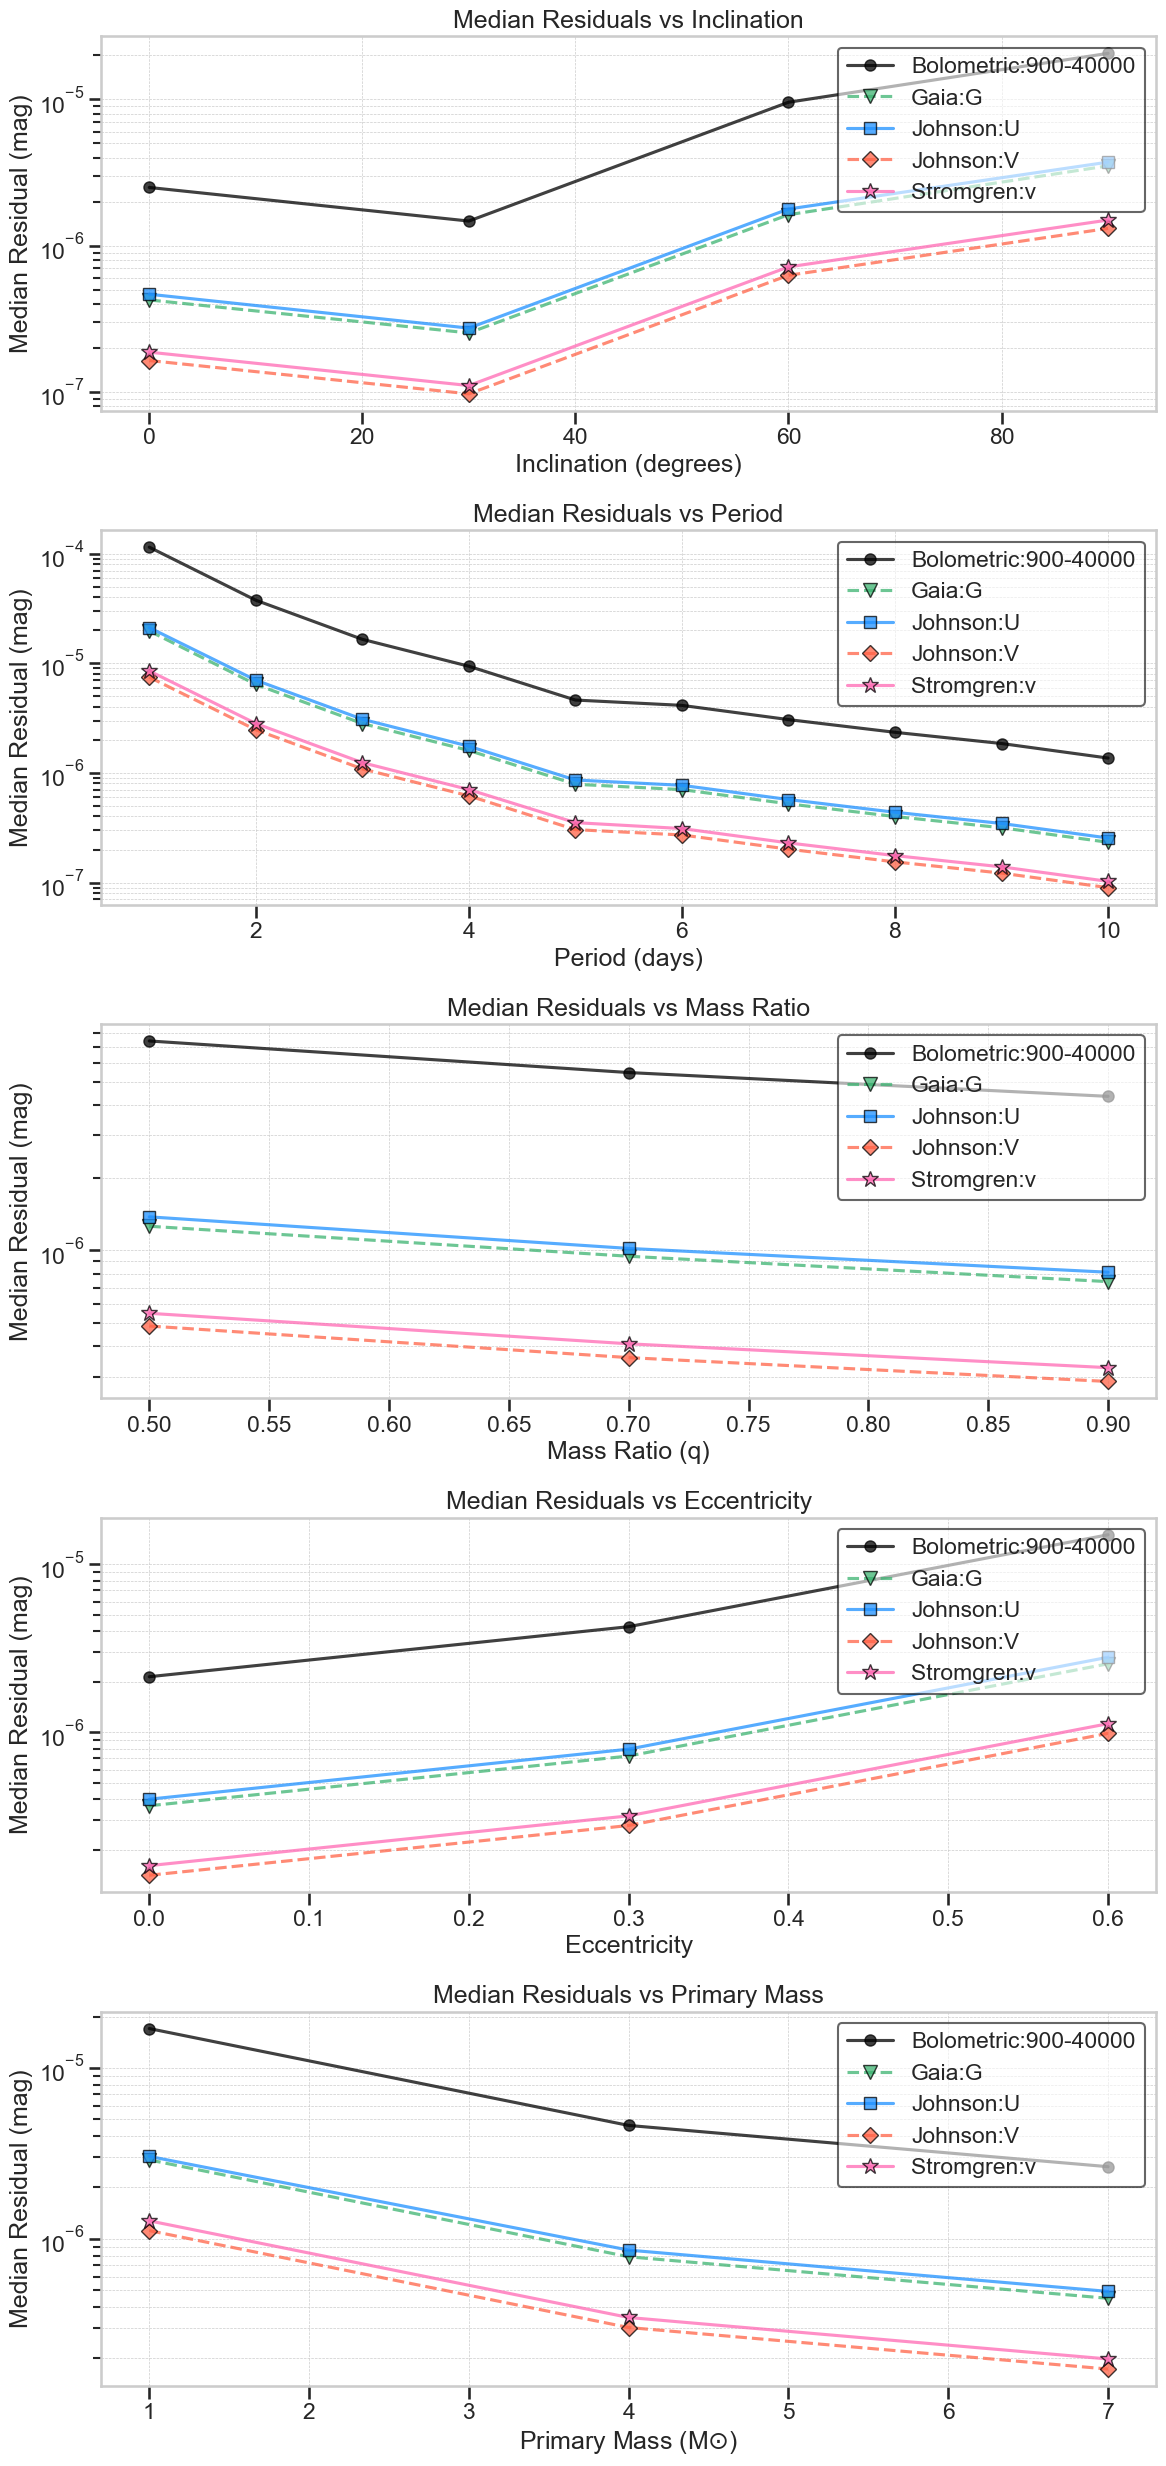

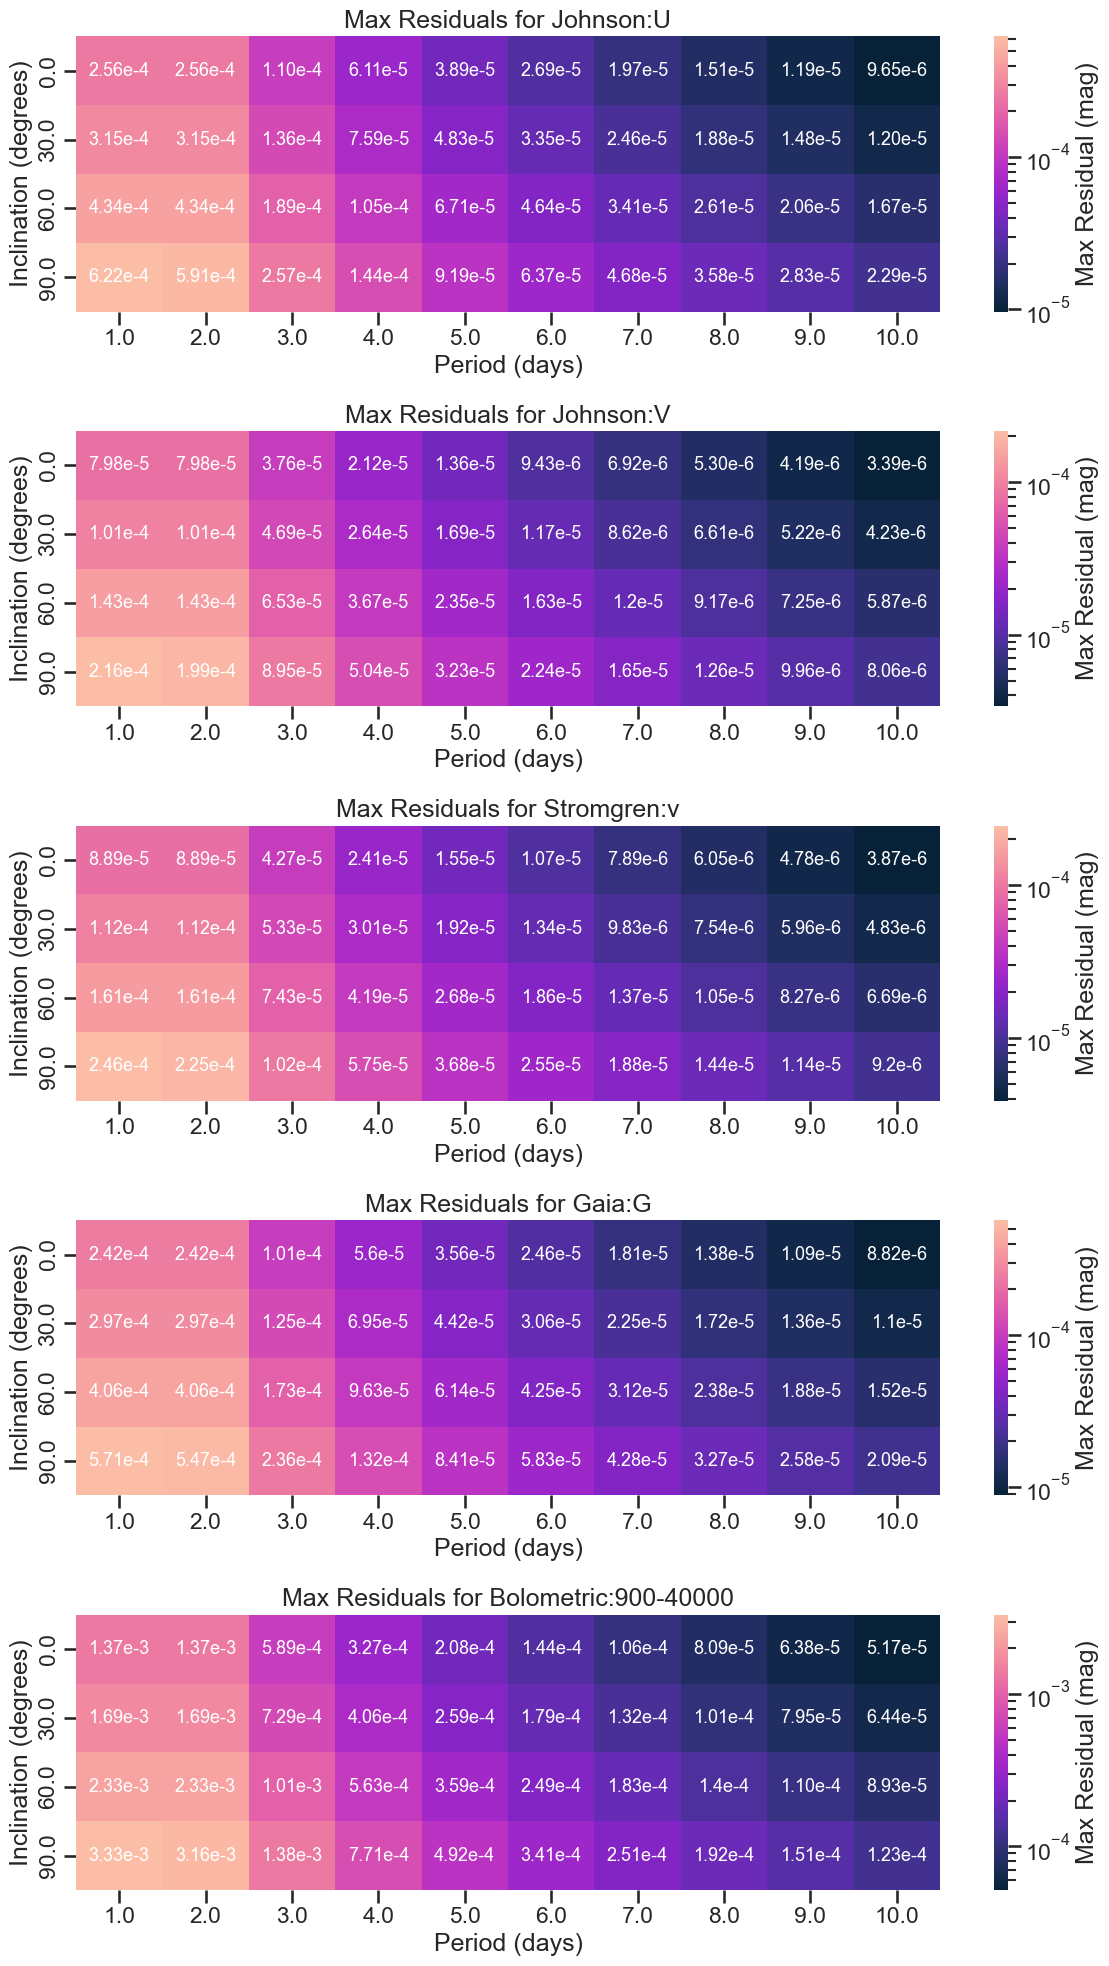

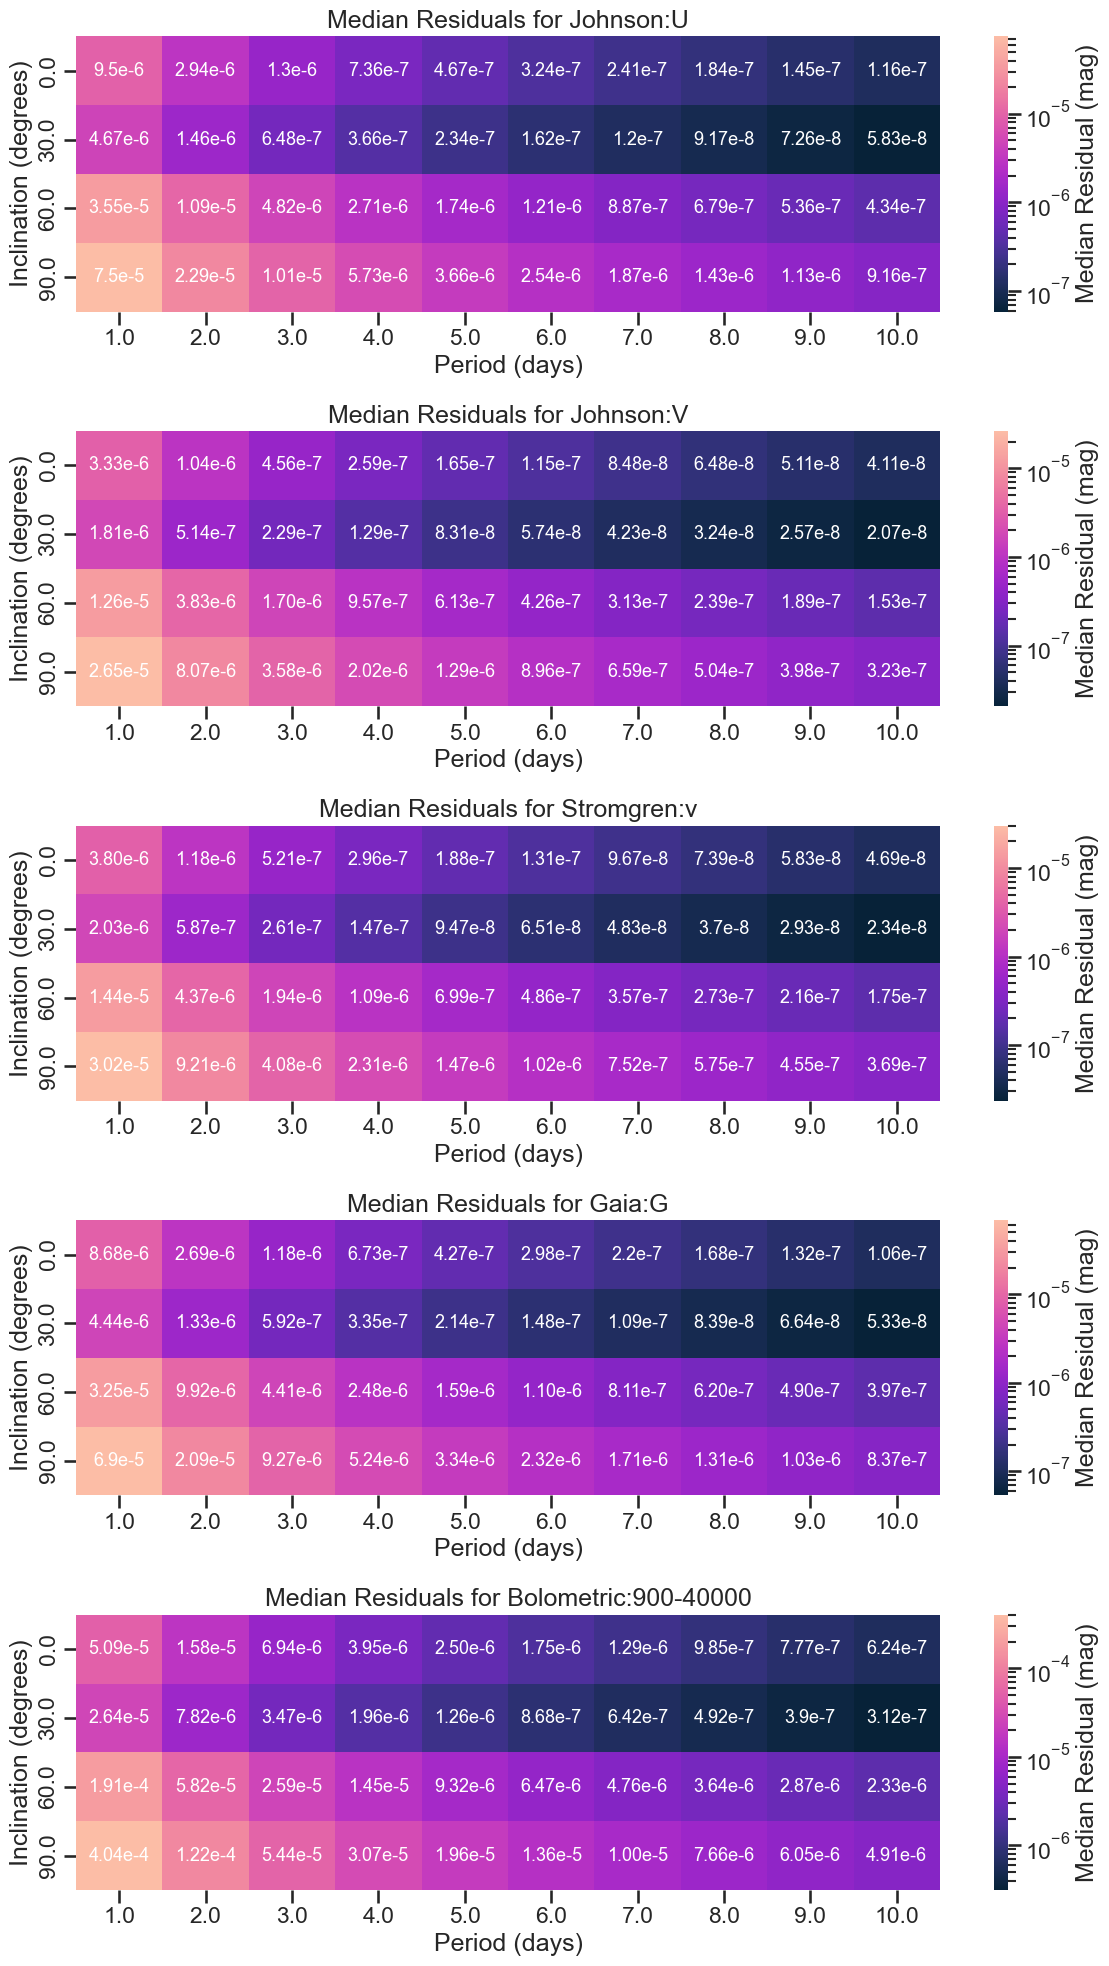

Summary of maximum residuals by filter:
                          mean    median       std  min       max
Filter                                                           
Bolometric:900-40000  0.000123  0.000020  0.000324  0.0  0.003332
Gaia:G                0.000021  0.000003  0.000056  0.0  0.000571
Johnson:U             0.000023  0.000004  0.000061  0.0  0.000622
Johnson:V             0.000008  0.000001  0.000021  0.0  0.000216
Stromgren:v           0.000009  0.000001  0.000023  0.0  0.000246

Top 10 parameter combinations with largest residuals:
                    Filter  Inclination  Period  Mass Ratio  Eccentricity  \
2049  Bolometric:900-40000         90.0     1.0         0.5           0.3   
1704  Bolometric:900-40000         90.0     1.0         0.5           0.6   
644   Bolometric:900-40000         90.0     2.0         0.5           0.6   
289   Bolometric:900-40000         60.0     2.0         0.5           0.6   
2454  Bolometric:900-40000         60.0     1.0         0.

In [27]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from matplotlib.colors import LogNorm
import cmasher as cmr

# Set up the plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")
colors = []

# Function to extract parameters from directory name
def extract_params(dirname):
    parts = dirname.split('_')
    incl = float(parts[1])
    period = float(parts[3])
    q = float(parts[5])
    ecc = float(parts[7])
    primary_mass = float(parts[10])
    return incl, period, q, ecc, primary_mass

# Find all result directories
result_dirs = glob.glob('results_close/incl_*') + glob.glob('results_medium/incl_*')

# Collect all max residuals
all_data = []

for dir_path in result_dirs:
    csv_path = os.path.join(dir_path, 'max_residuals.csv')
    if os.path.exists(csv_path):
        # Extract parameters from directory name
        incl, period, q, ecc, primary_mass = extract_params(os.path.basename(dir_path))
        
        # Skip cases with ecc=0.9
        if ecc == 0.9:
            continue
            
        # Read the max residuals
        df = pd.read_csv(csv_path)
        # Read the median residuals from the corresponding .txt files
        median_residuals = {}
        for filter_name in df['Filter']:
            txt_path = os.path.join(dir_path, f"{filter_name}.txt")
            if os.path.exists(txt_path):
                try:
                    # Load the residual values from the text file
                    residual_values = np.loadtxt(txt_path)
                    # Calculate the median of non-zero values (if any)
                    non_zero_values = residual_values[residual_values != 0]
                    if len(non_zero_values) > 0:
                        median_residual = np.median(non_zero_values)
                    else:
                        median_residual = 0.0
                    median_residuals[filter_name] = median_residual
                except Exception as e:
                    print(f"Error reading {txt_path}: {e}")
                    median_residuals[filter_name] = 0.0
            else:
                median_residuals[filter_name] = 0.0
        
        # Add median residuals to the dataframe
        df['Median Residual'] = df['Filter'].map(median_residuals)
        
        # Add parameters to the dataframe
        for _, row in df.iterrows():
            all_data.append({
                'Filter': row['Filter'],
                'Max Residual': row['Max Residual'],
                'Median Residual': row['Median Residual'],
                'Inclination': incl,
                'Period': period,
                'Mass Ratio': q,
                'Eccentricity': ecc,
                'Primary Mass': primary_mass
            })

# Convert to DataFrame
results_df = pd.DataFrame(all_data)

# Create a figure with subplots for each parameter
fig, axes = plt.subplots(5, 1, figsize=(12, 25))
parameters = ['Inclination', 'Period', 'Mass Ratio', 'Eccentricity', 'Primary Mass']
param_labels = ['Inclination (degrees)', 'Period (days)', 'Mass Ratio (q)', 'Eccentricity', 'Primary Mass (M$\odot$)']
colors = {
    'Bolometric:900-40000': 'black',
    'Gaia:G': 'mediumseagreen',
    'Johnson:U': 'dodgerblue',
    'Johnson:V': 'tomato',
    'Stromgren:v': 'hotpink'
}
marker_styles = {
    'Bolometric:900-40000': 'o',
    'Gaia:G': 'v',
    'Johnson:U': 's',
    'Johnson:V': 'D',
    'Stromgren:v': '*'
}
linestyles = {
    'Bolometric:900-40000': '-',
    'Gaia:G': '--',
    'Johnson:U': '-',
    'Johnson:V': '--',
    'Stromgren:v': '-'
}
marker_sizes = {
    'Bolometric:900-40000': 8,
    'Gaia:G': 10,
    'Johnson:U': 8,
    'Johnson:V': 8,
    'Stromgren:v': 12
}

for i, (param, label) in enumerate(zip(parameters, param_labels)):
    ax = axes[i]
    
    # Group by parameter and filter, then get the mean max residual
    grouped = results_df.groupby([param, 'Filter'])['Max Residual'].max().reset_index()
    
    # Plot for each filter
    for filter_name in grouped['Filter'].unique():
        filter_data = grouped[grouped['Filter'] == filter_name]
        ax.plot(filter_data[param], filter_data['Max Residual'], marker=marker_styles[filter_name],
                label=filter_name, color=colors[filter_name], linestyle=linestyles[filter_name],
                mec='black', ms=marker_sizes[filter_name], alpha=0.75)
    
    ax.set_xlabel(label)
    ax.set_ylabel('Max Residual (mag)')
    ax.set_yscale('log')
    ax.set_title(f'Maximum Residuals vs {param}')
    # Create legend with white background
    legend = ax.legend(facecolor='white', edgecolor='black', loc='upper right', framealpha=0.6, frameon=True)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('max_residuals_by_parameter.png', dpi=300, bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(5, 1, figsize=(12, 25))

for i, (param, label) in enumerate(zip(parameters, param_labels)):
    ax = axes[i]
    
    # Group by parameter and filter, then get the mean max residual
    grouped = results_df.groupby([param, 'Filter'])['Median Residual'].median().reset_index()
    
    # Plot for each filter
    for filter_name in grouped['Filter'].unique():
        filter_data = grouped[grouped['Filter'] == filter_name]
        ax.plot(filter_data[param], filter_data['Median Residual'], marker=marker_styles[filter_name],
                label=filter_name, color=colors[filter_name], linestyle=linestyles[filter_name],
                mec='black', ms=marker_sizes[filter_name], alpha=0.75)
    
    ax.set_xlabel(label)
    ax.set_ylabel('Median Residual (mag)')
    ax.set_yscale('log')
    ax.set_title(f'Median Residuals vs {param}')
    # Create legend with white background
    legend = ax.legend(facecolor='white', edgecolor='black', loc='upper right', framealpha=0.6, frameon=True)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('median_residuals_by_parameter.png', dpi=300, bbox_inches='tight')
plt.show()

# Create heatmaps for pairs of parameters
# We'll focus on inclination vs period for each filter
filters = results_df['Filter'].unique()

fig, axes = plt.subplots(len(filters), 1, figsize=(12, 4*len(filters)))
if len(filters) == 1:
    axes = [axes]

for i, filter_name in enumerate(filters):
    filter_data = results_df[results_df['Filter'] == filter_name]
    
    # Create pivot table for inclination vs period
    pivot = filter_data.pivot_table(
        index='Inclination', 
        columns='Period', 
        values='Max Residual',
        aggfunc='max'
    )
    
    # Plot heatmap
    heatmap = sns.heatmap(pivot, cmap=cmr.bubblegum, norm=LogNorm(), ax=axes[i], cbar_kws={'label': 'Max Residual (mag)'})
    
    # Add annotations with scientific notation in white
    for j in range(len(pivot.index)):
        for k in range(len(pivot.columns)):
            if not pd.isna(pivot.iloc[j, k]):
                axes[i].text(k + 0.5, j + 0.5,
                             str(np.format_float_scientific(pivot.iloc[j, k], precision=2, exp_digits=1)),
                           ha="center", va="center", color="white", fontsize=13)
    
    axes[i].set_title(f'Max Residuals for {filter_name}')
    axes[i].set_xlabel('Period (days)')
    axes[i].set_ylabel('Inclination (degrees)')

plt.tight_layout()
plt.savefig('max_residuals_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(len(filters), 1, figsize=(12, 4*len(filters)))
if len(filters) == 1:
    axes = [axes]

for i, filter_name in enumerate(filters):
    filter_data = results_df[results_df['Filter'] == filter_name]
    
    # Create pivot table for inclination vs period
    pivot = filter_data.pivot_table(
        index='Inclination', 
        columns='Period', 
        values='Median Residual',
        aggfunc='median'
    )
    
    # Plot heatmap
    heatmap = sns.heatmap(pivot, cmap=cmr.bubblegum, norm=LogNorm(), ax=axes[i], cbar_kws={'label': 'Median Residual (mag)'})
    
    # Add annotations with scientific notation in white
    for j in range(len(pivot.index)):
        for k in range(len(pivot.columns)):
            if not pd.isna(pivot.iloc[j, k]):
                axes[i].text(k + 0.5, j + 0.5,
                             str(np.format_float_scientific(pivot.iloc[j, k], precision=2, exp_digits=1)),
                           ha="center", va="center", color="white", fontsize=13)
    
    axes[i].set_title(f'Median Residuals for {filter_name}')
    axes[i].set_xlabel('Period (days)')
    axes[i].set_ylabel('Inclination (degrees)')

plt.tight_layout()
plt.savefig('median_residuals_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics
print("Summary of maximum residuals by filter:")
summary = results_df.groupby('Filter')['Max Residual'].agg(['mean', 'median', 'std', 'min', 'max'])
print(summary)

# Find the parameter combinations with the largest residuals
print("\nTop 10 parameter combinations with largest residuals:")
top_residuals = results_df.sort_values('Max Residual', ascending=False).head(10)
print(top_residuals[['Filter', 'Inclination', 'Period', 'Mass Ratio', 'Eccentricity', 'Primary Mass', 'Max Residual']])


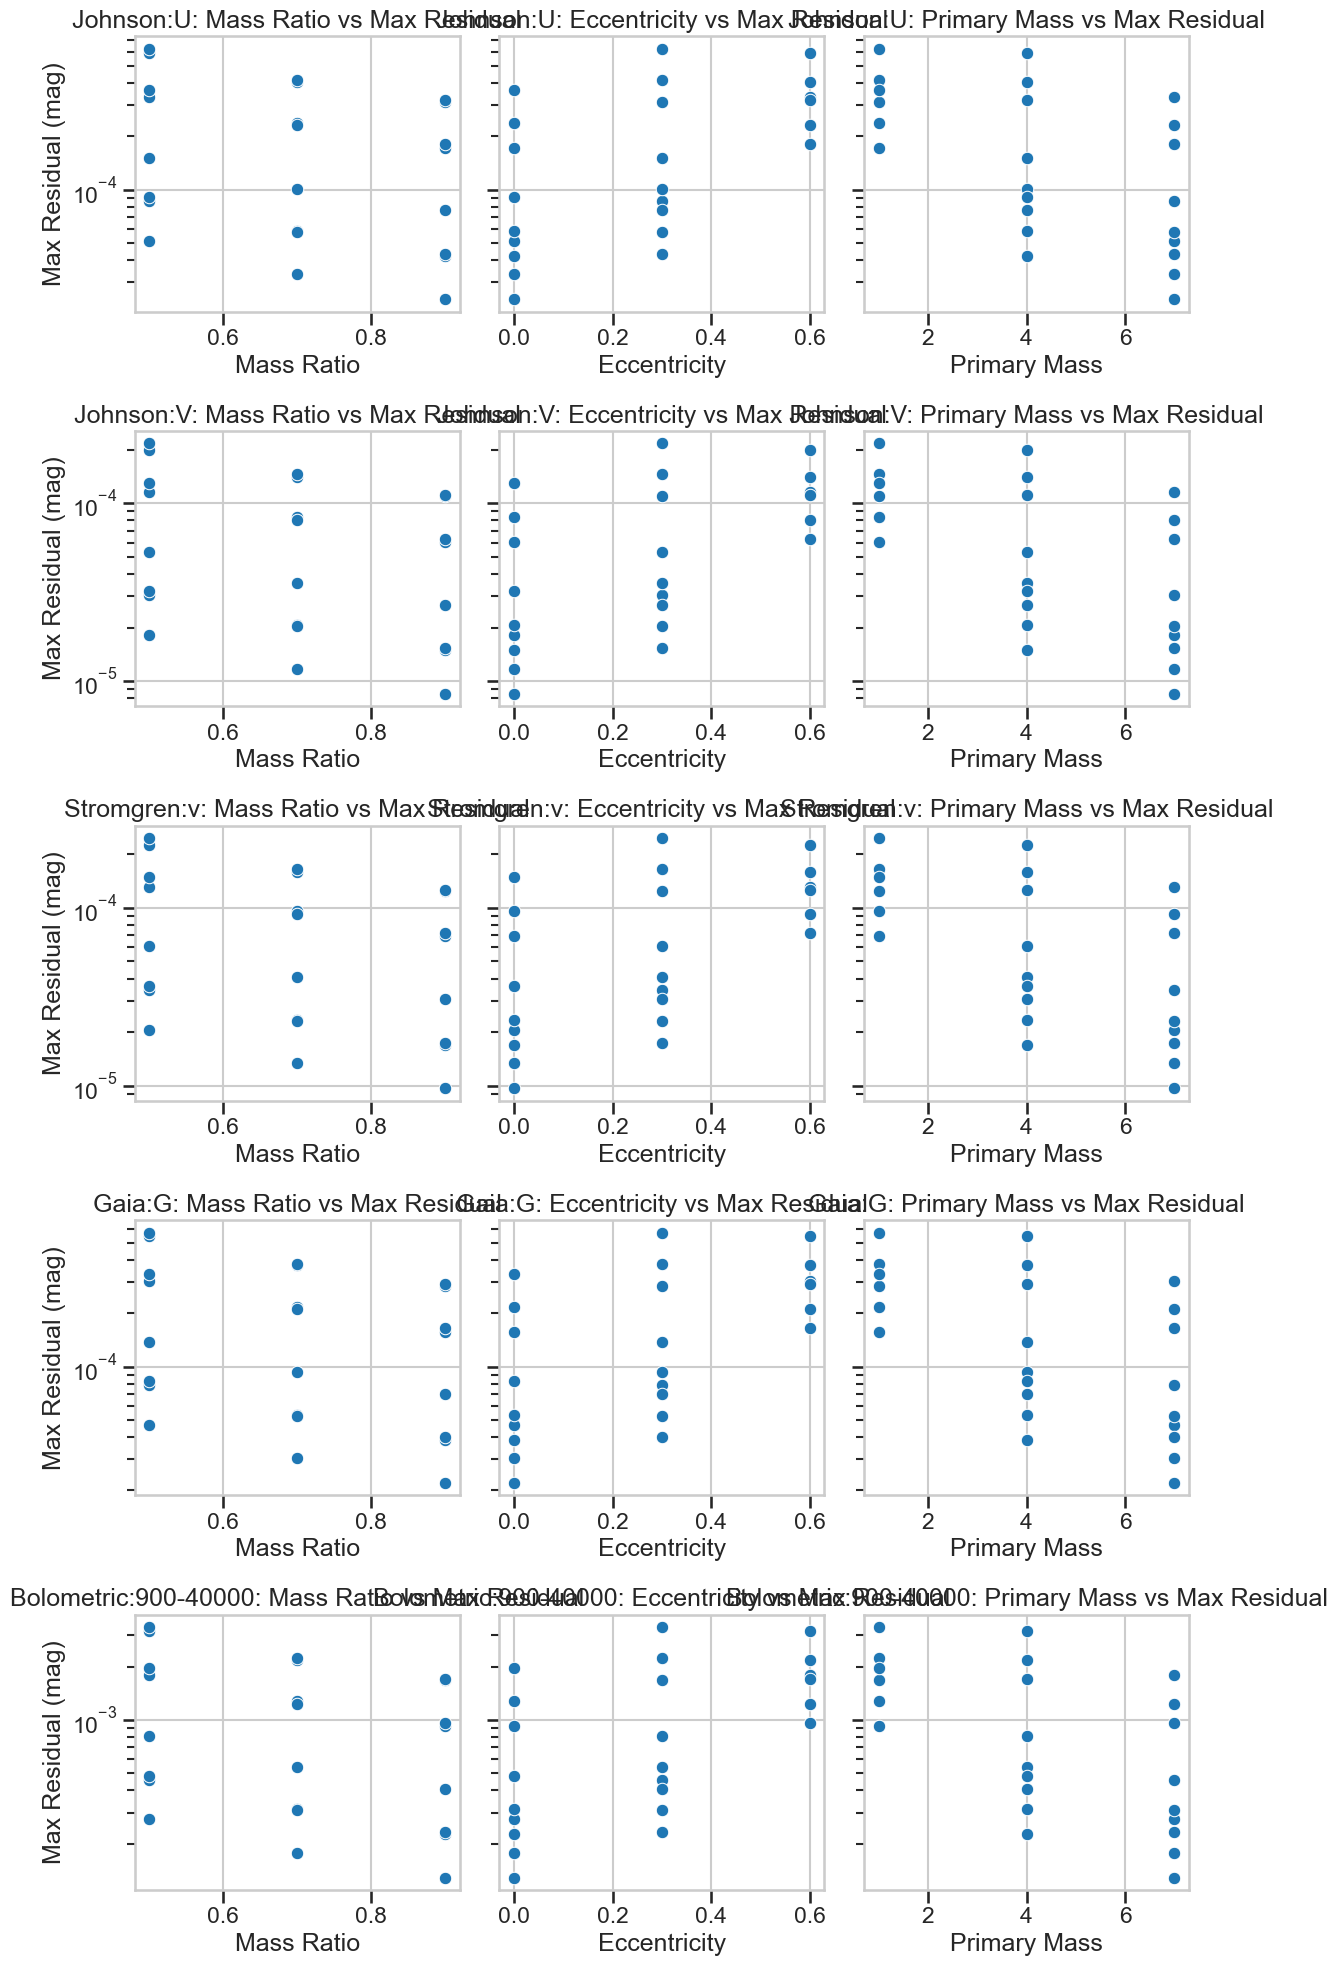


Summary for Inclination=90° and Period=1 day:
                   Filter  Mass Ratio  Eccentricity  Primary Mass  \
3    Bolometric:900-40000         0.5           0.3           1.0   
6    Bolometric:900-40000         0.5           0.6           4.0   
11   Bolometric:900-40000         0.7           0.3           1.0   
14   Bolometric:900-40000         0.7           0.6           4.0   
0    Bolometric:900-40000         0.5           0.0           1.0   
..                    ...         ...           ...           ...   
89              Johnson:V         0.9           0.0           4.0   
106           Stromgren:v         0.7           0.0           7.0   
82              Johnson:V         0.7           0.0           7.0   
114           Stromgren:v         0.9           0.0           7.0   
90              Johnson:V         0.9           0.0           7.0   

     Max Residual  
3        0.003332  
6        0.003161  
11       0.002221  
14       0.002180  
0        0.001962  
..  

In [5]:
# Filter data for inclination=90 and period=1
incl90_period1 = results_df[(results_df['Inclination'] == 90) & (results_df['Period'] == 1)]

if not incl90_period1.empty:
    # Create plots for other parameters
    other_params = ['Mass Ratio', 'Eccentricity', 'Primary Mass']
    
    fig, axes = plt.subplots(len(filters), len(other_params), figsize=(12, 4*len(filters)), sharey='row')
    
    # Handle case with single filter
    if len(filters) == 1:
        axes = [axes]
    
    for i, filter_name in enumerate(filters):
        filter_data = incl90_period1[incl90_period1['Filter'] == filter_name]
        
        for j, param in enumerate(other_params):
            ax = axes[i][j]
            
            # Create scatter plot
            sns.scatterplot(data=filter_data, x=param, y='Max Residual', ax=ax)
            
            ax.set_yscale('log')
            ax.set_title(f'{filter_name}: {param} vs Max Residual')
            ax.set_xlabel(param)
            
            if j == 0:
                ax.set_ylabel('Max Residual (mag)')
            else:
                ax.set_ylabel('')
    
    plt.tight_layout()
    plt.savefig('incl90_period1_parameter_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create a summary table for this specific case
    print("\nSummary for Inclination=90° and Period=1 day:")
    summary_90_1 = incl90_period1.groupby(['Filter', 'Mass Ratio', 'Eccentricity', 'Primary Mass'])['Max Residual'].mean().reset_index()
    summary_90_1 = summary_90_1.sort_values('Max Residual', ascending=False)
    print(summary_90_1)
else:
    print("No data available for inclination=90° and period=1 day")


Unique periods in the dataset: [ 2.  3.  5.  1.  4. 10.  9.  7.  8.  6.]


/var/folders/7r/n_x0ntj511v_0gt816mgrc1c0000gq/T/ipykernel_14712/1730744808.py:47: UserWarning: Glyph 9737 (\N{SUN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/7r/n_x0ntj511v_0gt816mgrc1c0000gq/T/ipykernel_14712/1730744808.py:48: UserWarning: Glyph 9737 (\N{SUN}) missing from font(s) Arial.
  plt.savefig('parameter_coverage_by_period.png', dpi=300, bbox_inches='tight')
/Users/mjablons/anaconda3/envs/astro/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9737 (\N{SUN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


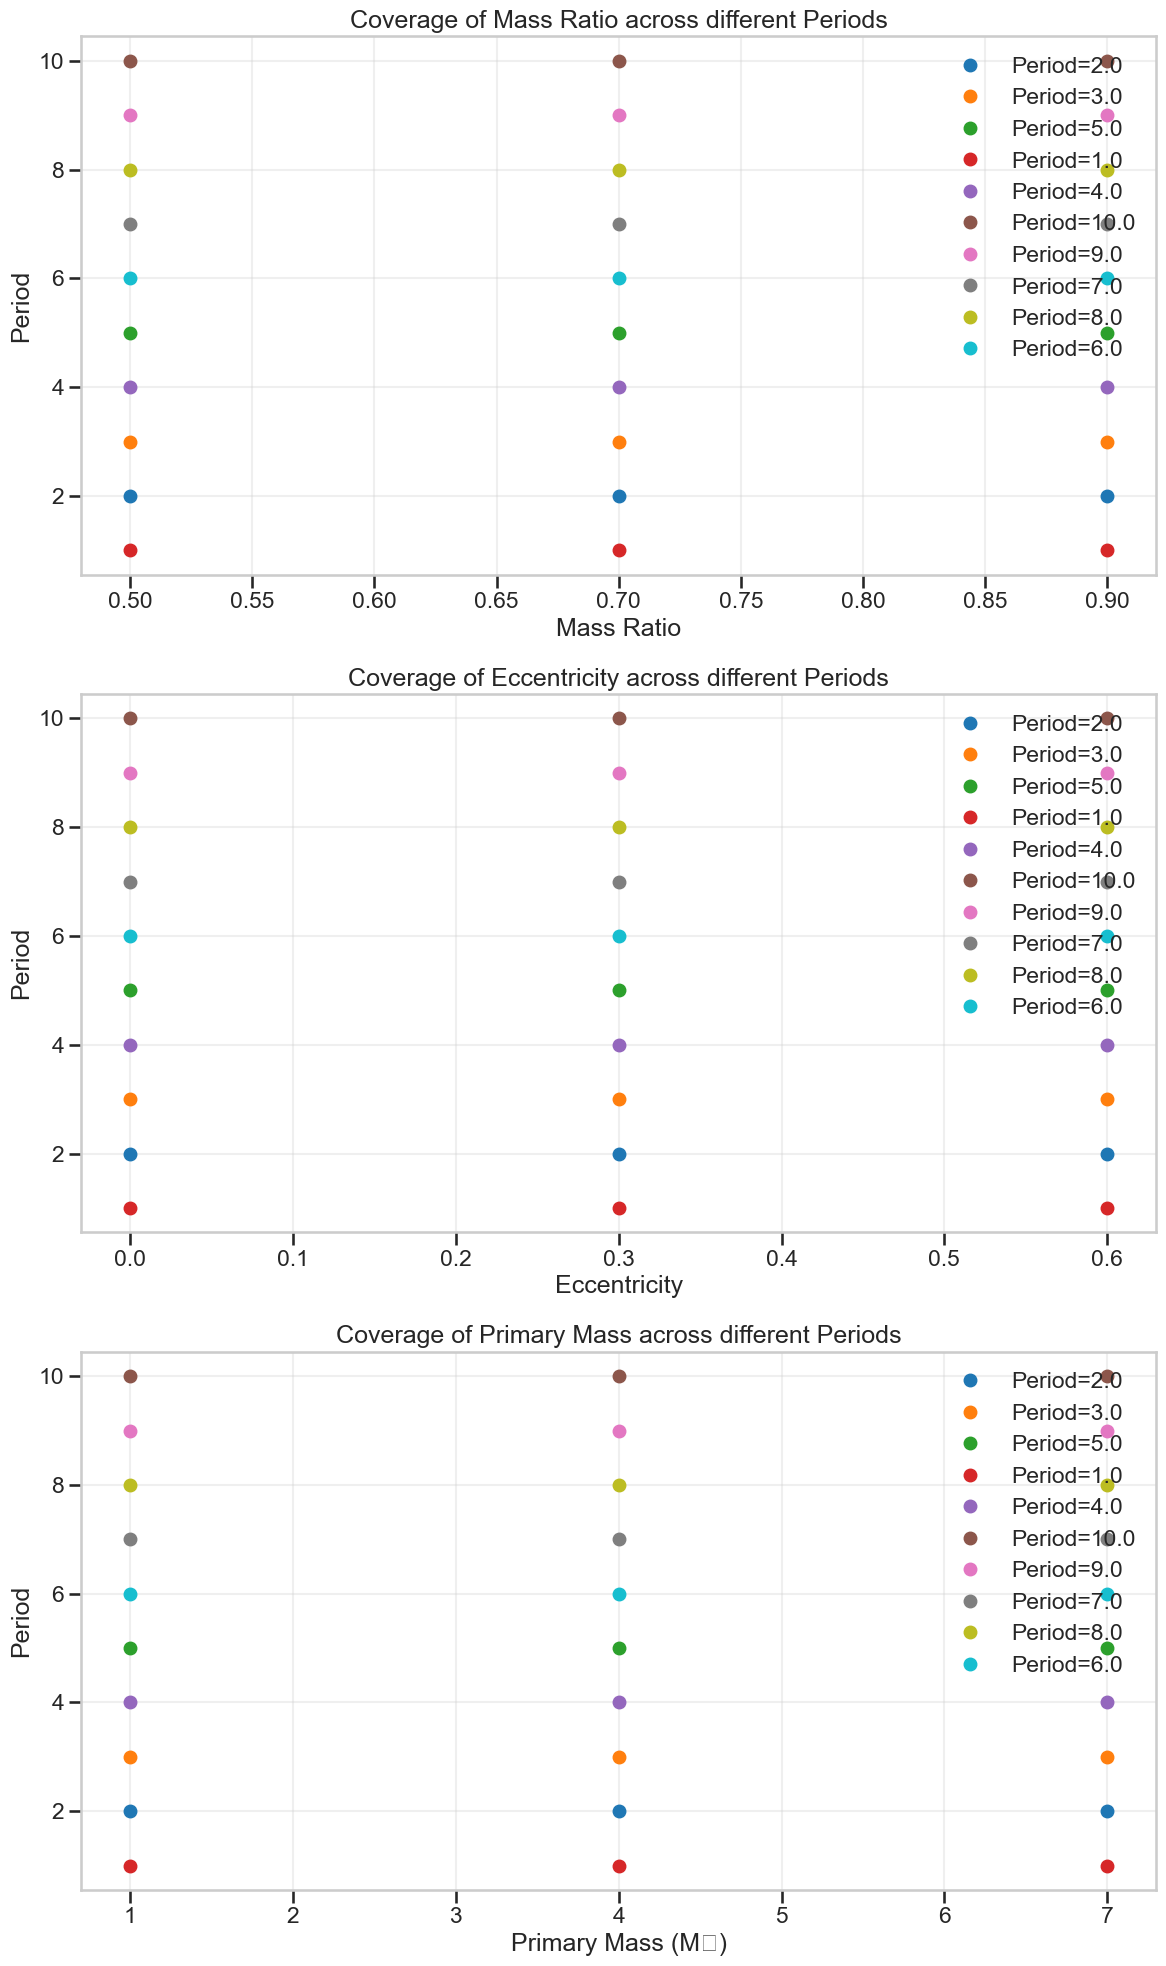


Parameter coverage summary by period:

Period = 2.0:
  Mass Ratio values: [0.5, 0.7, 0.9]
  Eccentricity values: [0.0, 0.3, 0.6]
  Primary Mass values: [1.0, 4.0, 7.0]
  Number of data points: 540

Period = 3.0:
  Mass Ratio values: [0.5, 0.7, 0.9]
  Eccentricity values: [0.0, 0.3, 0.6]
  Primary Mass values: [1.0, 4.0, 7.0]
  Number of data points: 540

Period = 5.0:
  Mass Ratio values: [0.5, 0.7, 0.9]
  Eccentricity values: [0.0, 0.3, 0.6]
  Primary Mass values: [1.0, 4.0, 7.0]
  Number of data points: 945

Period = 1.0:
  Mass Ratio values: [0.5, 0.7, 0.9]
  Eccentricity values: [0.0, 0.3, 0.6]
  Primary Mass values: [1.0, 4.0, 7.0]
  Number of data points: 480

Period = 4.0:
  Mass Ratio values: [0.5, 0.7, 0.9]
  Eccentricity values: [0.0, 0.3, 0.6]
  Primary Mass values: [1.0, 4.0, 7.0]
  Number of data points: 1080

Period = 10.0:
  Mass Ratio values: [0.5, 0.7, 0.9]
  Eccentricity values: [0.0, 0.3, 0.6]
  Primary Mass values: [1.0, 4.0, 7.0]
  Number of data points: 510

Peri

In [6]:
# Check if all periods have the same coverage of the rest of the parameters
unique_periods = results_df['Period'].unique()
print(f"Unique periods in the dataset: {unique_periods}")

# Create a figure to visualize parameter coverage across periods
fig, axes = plt.subplots(3, 1, figsize=(12, 20))

# Check Mass Ratio coverage
ax1 = axes[0]
for period in unique_periods:
    period_data = results_df[results_df['Period'] == period]
    unique_mass_ratios = period_data['Mass Ratio'].unique()
    ax1.plot(unique_mass_ratios, [period] * len(unique_mass_ratios), 'o', label=f'Period={period}')

ax1.set_xlabel('Mass Ratio')
ax1.set_ylabel('Period')
ax1.set_title('Coverage of Mass Ratio across different Periods')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Check Eccentricity coverage
ax2 = axes[1]
for period in unique_periods:
    period_data = results_df[results_df['Period'] == period]
    unique_eccentricities = period_data['Eccentricity'].unique()
    ax2.plot(unique_eccentricities, [period] * len(unique_eccentricities), 'o', label=f'Period={period}')

ax2.set_xlabel('Eccentricity')
ax2.set_ylabel('Period')
ax2.set_title('Coverage of Eccentricity across different Periods')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Check Primary Mass coverage
ax3 = axes[2]
for period in unique_periods:
    period_data = results_df[results_df['Period'] == period]
    unique_primary_masses = period_data['Primary Mass'].unique()
    ax3.plot(unique_primary_masses, [period] * len(unique_primary_masses), 'o', label=f'Period={period}')

ax3.set_xlabel('Primary Mass (M☉)')
ax3.set_ylabel('Period')
ax3.set_title('Coverage of Primary Mass across different Periods')
ax3.grid(True, alpha=0.3)
ax3.legend()

plt.tight_layout()
plt.savefig('parameter_coverage_by_period.png', dpi=300, bbox_inches='tight')
plt.show()

# Print a summary of parameter coverage for each period
print("\nParameter coverage summary by period:")
for period in unique_periods:
    period_data = results_df[results_df['Period'] == period]
    print(f"\nPeriod = {period}:")
    print(f"  Mass Ratio values: {sorted(period_data['Mass Ratio'].unique())}")
    print(f"  Eccentricity values: {sorted(period_data['Eccentricity'].unique())}")
    print(f"  Primary Mass values: {sorted(period_data['Primary Mass'].unique())}")
    print(f"  Number of data points: {len(period_data)}")
